In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv("wdbc.csv", header=None)

df_raw

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
device = "cpu"

In [4]:
y = pd.get_dummies(df_raw.iloc[:,1:2])

y = torch.Tensor(y.values).to(device)

y

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]])

In [5]:
x = df_raw.iloc[:,2:]

x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values).to(device)

x

tensor([[0.5210, 0.0227, 0.5460,  ..., 0.9120, 0.5985, 0.4189],
        [0.6431, 0.2726, 0.6158,  ..., 0.6392, 0.2336, 0.2229],
        [0.6015, 0.3903, 0.5957,  ..., 0.8351, 0.4037, 0.2134],
        ...,
        [0.4553, 0.6212, 0.4458,  ..., 0.4873, 0.1287, 0.1519],
        [0.6446, 0.6635, 0.6655,  ..., 0.9107, 0.4971, 0.4523],
        [0.0369, 0.5015, 0.0285,  ..., 0.0000, 0.2574, 0.1007]])

In [6]:
class Autoencoder(nn.Module):
    # Layers is an array of integers representing the encoder architecture
    # Example: 30 --> 3 --> 30: layers = [30, 3]
    def __init__(self, layers):
        super().__init__()
        self.in_dim = layers[0]
        self.activation = nn.Sigmoid()
        self.layers = layers
        
        # Encoder
        self.encoder_layers = []
        
        for i in range(len(layers) - 1):
            self.encoder_layers.append(nn.Linear(layers[i], layers[i+1]))
            self.encoder_layers.append(nn.Sigmoid())
        
        self.encoder_sequence = nn.Sequential(*self.encoder_layers)
            
        # Decoder
        self.decoder_layers = []
        
#         for i in range(len(layers) - 1, 0, -1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i - 1]))
#             self.decoder_layers.append(nn.Sigmoid())
    
#         layers.reverse()
#         for i in range(len(layers) - 1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i+1]))
#             self.decoder_layers.append(nn.Sigmoid())

        reversed_layers = sorted(layers, reverse=False)
        for i in range(len(reversed_layers) - 1):
            self.decoder_layers.append(nn.Linear(reversed_layers[i], reversed_layers[i+1]))
            self.decoder_layers.append(nn.Sigmoid())
        
        self.decoder_sequence = nn.Sequential(*self.decoder_layers)
        
    def encode(self, x):
        return self.encoder_sequence(x)
    
    def decode(self, x):
        return self.decoder_sequence(x)
    
    def forward(self, x):
        x = self.encode(x)
        y = self.decode(x)
        return y

In [7]:
model = Autoencoder([30, 20, 3])

print(model)

Autoencoder(
  (activation): Sigmoid()
  (encoder_sequence): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Sigmoid()
  )
)


In [8]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [9]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [10]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "autoencoder.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 658.94it/s, loss=0.0497]

Ave Loss: 0.05769123702326365
Epoch: 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 792.76it/s, loss=0.0472]


Ave Loss: 0.024796148141225178
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 712.10it/s, loss=0.047]


Ave Loss: 0.021709094199825796
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 716.80it/s, loss=0.0468]


Ave Loss: 0.02116701887969516
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 710.22it/s, loss=0.0465]


Ave Loss: 0.020919173004171045
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 665.03it/s, loss=0.0461]


Ave Loss: 0.020705577104532143
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 622.17it/s, loss=0.0454]


Ave Loss: 0.020447337236092017
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 720.56it/s, loss=0.0445]


Ave Loss: 0.020085564908457167
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 711.93it/s, loss=0.0433]


Ave Loss: 0.019615309051515765
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 760.43it/s, loss=0.042]


Ave Loss: 0.019062239823764877
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 668.31it/s, loss=0.0405]


Ave Loss: 0.01844971760159783
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 649.26it/s, loss=0.0389]


Ave Loss: 0.01779338083507722
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 730.52it/s, loss=0.0372]


Ave Loss: 0.017100403955402344
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 644.39it/s, loss=0.0353]


Ave Loss: 0.016376697621716743
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 662.31it/s, loss=0.0334]


Ave Loss: 0.015634027509868406
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 630.67it/s, loss=0.0314]


Ave Loss: 0.014893588748874894
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 750.13it/s, loss=0.0294]


Ave Loss: 0.014184966634370778
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 672.45it/s, loss=0.0276]


Ave Loss: 0.013540607370566903
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 647.18it/s, loss=0.026]


Ave Loss: 0.012987366581352003
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 655.00it/s, loss=0.0246]


Ave Loss: 0.012538743399394056
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 587.32it/s, loss=0.0235]


Ave Loss: 0.01219216266263015
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 767.27it/s, loss=0.0225]


Ave Loss: 0.011932570630227003
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 787.84it/s, loss=0.0218]


Ave Loss: 0.011739350961553947
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 715.25it/s, loss=0.0211]


Ave Loss: 0.011592464478637435
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 651.64it/s, loss=0.0206]


Ave Loss: 0.01147566523133336
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 725.38it/s, loss=0.0201]


Ave Loss: 0.011376984488921599
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 726.23it/s, loss=0.0197]


Ave Loss: 0.01128764498137395
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 536.00it/s, loss=0.0193]


Ave Loss: 0.011200596392563168
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 725.68it/s, loss=0.0189]


Ave Loss: 0.011110438330082647
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 707.77it/s, loss=0.0185]


Ave Loss: 0.011016915683030036
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 643.63it/s, loss=0.0182]


Ave Loss: 0.010926797408038718
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 674.88it/s, loss=0.0178]


Ave Loss: 0.010845167707374091
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 661.76it/s, loss=0.0174]


Ave Loss: 0.010770850159276864
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 754.44it/s, loss=0.0171]


Ave Loss: 0.01070110478618166
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 754.89it/s, loss=0.0168]


Ave Loss: 0.010633790007743397
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 692.19it/s, loss=0.0164]


Ave Loss: 0.010567436223490196
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 637.11it/s, loss=0.0161]


Ave Loss: 0.01050156330395686
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 754.26it/s, loss=0.0158]


Ave Loss: 0.010437042738327332
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 731.26it/s, loss=0.0156]


Ave Loss: 0.01037559352137083
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 700.90it/s, loss=0.0153]


Ave Loss: 0.010318673618154176
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 768.97it/s, loss=0.015]


Ave Loss: 0.010266954426473955
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 673.23it/s, loss=0.0148]


Ave Loss: 0.010220485786384527
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 742.01it/s, loss=0.0146]


Ave Loss: 0.010178985831883262
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 672.23it/s, loss=0.0144]


Ave Loss: 0.01014202784362919
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 712.23it/s, loss=0.0142]


Ave Loss: 0.010109141187154148
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 671.51it/s, loss=0.014]


Ave Loss: 0.010079859649729832
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 767.19it/s, loss=0.0139]


Ave Loss: 0.010053742971075209
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 721.98it/s, loss=0.0138]


Ave Loss: 0.010030386338353549
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 624.29it/s, loss=0.0137]


Ave Loss: 0.010009422996326497
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 590.79it/s, loss=0.0136]


Ave Loss: 0.009990525205227497
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 637.60it/s, loss=0.0135]


Ave Loss: 0.00997340234135392
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 647.16it/s, loss=0.0134]


Ave Loss: 0.009957799675727361
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 622.55it/s, loss=0.0133]


Ave Loss: 0.009943495968177
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 648.29it/s, loss=0.0133]


Ave Loss: 0.009930300495685324
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 701.85it/s, loss=0.0132]


Ave Loss: 0.00991804979275912
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 648.84it/s, loss=0.0131]


Ave Loss: 0.009906606368818566
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 645.63it/s, loss=0.0131]


Ave Loss: 0.00989585433547434
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 740.52it/s, loss=0.0131]


Ave Loss: 0.009885696800458327
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 878.76it/s, loss=0.013]


Ave Loss: 0.009876053222749186
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 862.98it/s, loss=0.013]


Ave Loss: 0.009866856671706364
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 655.80it/s, loss=0.013]


Ave Loss: 0.009858051116839704
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 668.82it/s, loss=0.013]


Ave Loss: 0.009849589142392864
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 715.65it/s, loss=0.0129]


Ave Loss: 0.009841430325698303
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 749.18it/s, loss=0.0129]


Ave Loss: 0.009833539409252504
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 696.76it/s, loss=0.0129]


Ave Loss: 0.009825884677028577
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 738.70it/s, loss=0.0129]


Ave Loss: 0.00981843829759511
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 680.07it/s, loss=0.0129]


Ave Loss: 0.009811174148987783
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 754.48it/s, loss=0.0129]


Ave Loss: 0.009804067879980593
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 687.69it/s, loss=0.0129]


Ave Loss: 0.00979709671606032
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 699.91it/s, loss=0.0129]


Ave Loss: 0.009790238015468052
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 655.26it/s, loss=0.0129]


Ave Loss: 0.009783470533428746
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 797.08it/s, loss=0.0129]


Ave Loss: 0.009776771910031113
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 800.59it/s, loss=0.0129]


Ave Loss: 0.009770120528788027
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 703.96it/s, loss=0.0129]


Ave Loss: 0.009763493339465768
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 740.52it/s, loss=0.0129]


Ave Loss: 0.009756866286982569
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 633.12it/s, loss=0.0129]


Ave Loss: 0.009750212124026004
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 609.52it/s, loss=0.0129]


Ave Loss: 0.009743501489426484
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 675.36it/s, loss=0.0129]


Ave Loss: 0.009736699789452056
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 652.10it/s, loss=0.0129]


Ave Loss: 0.009729766225638358
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 619.10it/s, loss=0.0129]


Ave Loss: 0.009722651607405982
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 637.53it/s, loss=0.0129]


Ave Loss: 0.009715295527457144
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 665.56it/s, loss=0.0129]


Ave Loss: 0.009707621874679861
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 693.46it/s, loss=0.0129]


Ave Loss: 0.009699535525501951
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 753.72it/s, loss=0.0129]


Ave Loss: 0.009690916063590791
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 627.17it/s, loss=0.0129]


Ave Loss: 0.009681612414536639
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 779.56it/s, loss=0.0129]


Ave Loss: 0.009671435205331235
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 664.24it/s, loss=0.0129]


Ave Loss: 0.009660145894853039
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 693.21it/s, loss=0.0129]


Ave Loss: 0.009647438923517862
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 690.94it/s, loss=0.0129]


Ave Loss: 0.009632913181313166
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 737.83it/s, loss=0.0129]


Ave Loss: 0.009616024755431633
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 589.42it/s, loss=0.0129]


Ave Loss: 0.009596014889610703
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 694.30it/s, loss=0.0129]


Ave Loss: 0.009571809368616525
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 603.89it/s, loss=0.0128]


Ave Loss: 0.009541894985248515
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 812.02it/s, loss=0.0128]


Ave Loss: 0.009504202908525864
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 611.71it/s, loss=0.0127]


Ave Loss: 0.009456081959222885
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 573.79it/s, loss=0.0126]


Ave Loss: 0.009394482715594532
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 815.43it/s, loss=0.0125]


Ave Loss: 0.009316317755483874
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 821.44it/s, loss=0.0123]


Ave Loss: 0.009218586108385864
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 722.68it/s, loss=0.0121]


Ave Loss: 0.009098026787110587
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 730.07it/s, loss=0.0119]

Ave Loss: 0.008951359026117675


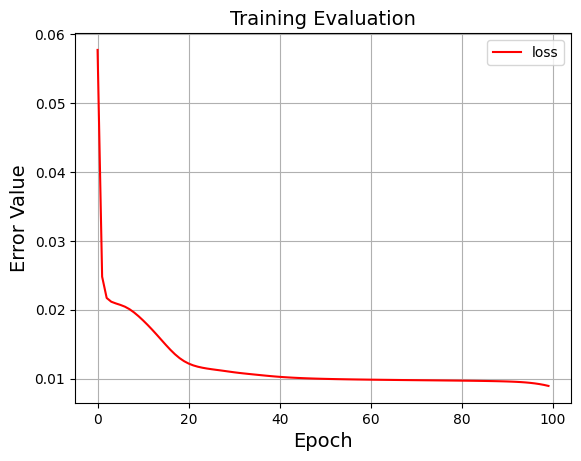

In [11]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [14]:
compressed_data = model.encode(x)

df_compressed_data = pd.DataFrame(compressed_data.detach().cpu().numpy())

df_compressed_data

,0,1,2
0,0.289095,0.142178,0.006207
1,0.514131,0.707945,0.015899
2,0.367265,0.386865,0.008827
3,0.855792,0.060124,0.023461
4,0.436368,0.561726,0.013533
...,...,...,...
564,0.214203,0.507287,0.007617
565,0.416800,0.606628,0.013527
566,0.773605,0.631200,0.033122
567,0.257371,0.100963,0.004989
